# Descrição de Atividade

Nesta atividade construiremos modelos preditivos de regressão em scikit learn para a predição dos votos de deputados federais considerando as últimas eleições. As atividades esperadas para essa etapa são descritas a seguir:

Baixe os dados [aqui](https://canvas.instructure.com/courses/1389733/files/69523670/download?verifier=A5EPvssqIQCjlxpWQyesLFer1VDTlRyTAAXR2iyi&wrap=1) (veja descrição dos dados mais abaixo).

Considere o pipeline mostrado nesse [link](https://www.kaggle.com/apapiu/regularized-linear-models) para construir seus modelos de regressão. 

Isso implica, dentre outras coisas:
1. Analisar as distribuições das variáveis para ver se estão enviesadas e precisam de correção;
2. Fazer tratamento de valores ausentes, variáveis categóricas e normalização, quando for o caso;
3. Construir modelos de regressão com (ridge e lasso) e sem regularização;
4. Considerar também modelos de regressão não paramétrica como KNN;
5. Considerar outros modelos ainda não vistos em sala de sua escolha (e.g. SVR, Regression Trees e Random Florests);
6. Tunar os hiperâmetros para cada caso e retornar os rmses de validação cruzada para todos os modelos avaliados;
7. Plotar os resíduos versus predições e analisar se esses plots representam bons indícios da adequabilidade dos modelos a esse problema;

Alguns dias antes da entrega final serão liberados os dados de teste referentes à 2014 para validação final dos seus melhores modelos.

_**Dica**: Uma coisa que você pode fazer é usar os dados de 2006 como treino e os de 2010 como validação. Uma vez encontrados os melhores modelos para 2010 junte 2006+2010, retreine, e aplique o modelo aos dados de 2014 que serão liberados._

## Responder:
### Dentre os modelos avaliados, qual foi o que deu o melhor resultado nos dados de 2014 em termos de RMSE? Justifique bem sua resposta.

A entrega deve ser um notebook Jupyter com código python e texto explicativo quando necessário. Crie um repositório na sua conta do github e envie o link do html do notebook.

**Sobre os dados**

Vamos explorar dados sobre as votações que candidatos à Câmara Federal de Deputados receberam nos anos de 2006 e 2010. Esses dados foram extraídos do [TSE](http://www.tse.jus.br/hotSites/pesquisas-eleitorais/index.html), pré-processados e contemplam informações sobre aproximadamente 7.300 candidatos. A descrição de cada atributo é dada mais abaixo.

* **sequencial_candidato**:  (character) id do candidato
* **nome**: (character)
* **uf**: (character)
* **partido**: (character)
* **quantidade_doacoes** : (integer)
* **quantidade_doadores**: (integer) numero de doadores diferentes
* **total_receita**: (double) soma em reais das doacoes
* **media_receita**: (double) media das doacoes
* **recursos_de_outros_candidatos_por_comite**: (double) quantia em reais das doacoes provenientes de outros candidatos ou comite partidário
* **recursos_de_pessoas_fisicas**: (double) quantia em reais das doacoes provenientes de outros CPFs
* **recursos_de_pessoas_juridicas**: (double) quantia em reais das doacoes provenientes de outros CNPJ
* **recursos_proprios**: (double) quantia em reais das doacoes provenientes do proprio candidato
* **recursos_de_partido_politico**: (double) quantia em reais das doacoes provenientes do partido politico do candidato
* **votos**: (integer) variavel alvo. Se refere ao numero de votos na campanha de 2006 e 2010
* **quantidade_despesas**: (integer)
* **quantidade_fornecedores**: (integer) numero de fornecedores por despesas diferentes
* **total_despesa**: (double) soma em reais das despesas de campanha
* **media_despesa**: (double) media das despesas de campanha
* **cargo**: (character)
* **sexo**:  (character)
* **grau**: (character) grau de instrucao do candidato
* **estado_civil**: (character)
* **ocupacao**: (character) ocupacao do candidato

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

sns.set(style="ticks")

%matplotlib inline

## Load Data

In [2]:
candidates_df = pd.read_csv('../data/eleicoes_2006_a_2010.csv')
candidates_df.shape

(7330, 23)

### Split Train and Test Data

In [3]:
candidates_df = candidates_df.drop(columns=['sequencial_candidato', 'nome'])

## EDA - Exploratory Data Analysis

Inicialmente, devemos fazer uma análise exploratória dos dados para descobrir como eles estão distribuídos, se possuem valores extraordinários (outliers) e se tem alguma correlação mais forte entre si, especialmente com a variável alvo (**votos**).

In [4]:
candidates_df.columns

Index(['ano', 'uf', 'partido', 'quantidade_doacoes', 'quantidade_doadores',
       'total_receita', 'media_receita',
       'recursos_de_outros_candidatos_comites', 'recursos_de_pessoas_fisicas',
       'recursos_de_pessoas_juridicas', 'recursos_proprios',
       'quantidade_despesas', 'quantidade_fornecedores', 'total_despesa',
       'media_despesa', 'cargo', 'sexo', 'grau', 'estado_civil', 'ocupacao',
       'votos'],
      dtype='object')

In [5]:
candidates_df.describe(exclude=['category', 'object'])

,ano,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos_comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,votos
count,7330.000000,7330.000000,7330.000000,7.169000e+03,7169.000000,4.940000e+03,4.647000e+03,3.354000e+03,4.942000e+03,7330.000000,7330.000000,7.330000e+03,7330.000000,7.330000e+03
mean,2008.151160,28.310095,25.817462,1.544899e+05,5485.597708,3.002116e+04,3.730931e+04,1.761195e+05,3.914169e+04,133.339836,110.179945,1.588707e+05,1500.033736,2.280617e+04
std,1.994416,118.655091,103.659438,3.953880e+05,14116.531491,1.280932e+05,8.215398e+04,3.517541e+05,1.839980e+05,416.838801,338.493008,3.951814e+05,6363.830635,4.810133e+04
min,2006.000000,1.000000,1.000000,0.000000e+00,0.000000,2.410000e+00,3.000000e-02,0.000000e+00,0.000000e+00,1.000000,1.000000,0.000000e+00,0.000000,2.000000e+00
25%,2006.000000,4.000000,4.000000,2.700000e+03,622.857143,1.180000e+03,2.000000e+03,3.422500e+03,1.177233e+03,6.000000,5.000000,2.781405e+03,398.452936,8.600000e+02
50%,2010.000000,9.000000,8.000000,1.209578e+04,1540.542500,3.522570e+03,9.000000e+03,2.612000e+04,5.000000e+03,21.000000,18.000000,1.297986e+04,794.678212,3.025000e+03
75%,2010.000000,24.000000,22.000000,8.929956e+04,4662.500000,1.327550e+04,3.756234e+04,1.755218e+05,2.027459e+04,83.000000,71.000000,1.006515e+05,1564.290552,2.027450e+04
max,2010.000000,6997.000000,5800.000000,4.539727e+06,500180.000000,3.664205e+06,1.403049e+06,3.178226e+06,5.525600e+06,9932.000000,8359.000000,4.989491e+06,500177.000000,1.353820e+06


A tabela acima já nos permite tirar uma série de insights sobre os dados que temos, entretando precisamos investigar a existência de valores estranhos no nosso dataset, como valores não-numéricos (NaN) em variáveis numéricas:

In [6]:
for col in candidates_df.columns:
    amount_nan = candidates_df[str(col)].isna().sum()
    if amount_nan > 0:
        print("Column [{:02}]: {:40} - Amount NaN: {}".format(candidates_df.columns.get_loc(str(col)), str(col), amount_nan))

Column [05]: total_receita                            - Amount NaN: 161
Column [06]: media_receita                            - Amount NaN: 161
Column [07]: recursos_de_outros_candidatos_comites    - Amount NaN: 2390
Column [08]: recursos_de_pessoas_fisicas              - Amount NaN: 2683
Column [09]: recursos_de_pessoas_juridicas            - Amount NaN: 3976
Column [10]: recursos_proprios                        - Amount NaN: 2388


Para essas variáveis não podemos ter valores não numéricos, então vamos colocar esses valores para 0.0, uma vez que são valores de receita e recursos.

In [7]:
candidates_df.total_receita.fillna(0, inplace=True)
candidates_df.media_receita.fillna(0, inplace=True)
candidates_df.recursos_de_outros_candidatos_comites.fillna(0, inplace=True)
candidates_df.recursos_de_pessoas_fisicas.fillna(0, inplace=True)
candidates_df.recursos_de_pessoas_juridicas.fillna(0, inplace=True)
candidates_df.recursos_proprios.fillna(0, inplace=True)

### Calculando Skewness de Variáveis Numéricas

Aqui nós transformamos skewed features para que tenham uma distribuição mais normalizada. Ter uma distribuição mais normalizada nos garante um maior arsenal de ferramentas estatísticas e computacionais que podemos utilizar, assim como torna a análise dos dados mais conveniente para nós.

Nós utilizamos o **log(1 + x)** em vez de apenas **log(x)**, uma vez que o log de 0 não existe, e várias de nossas variáveis tem esses valores, como as que preenchemos em substituição a NaN na seção acima. Além disso, como estamos lidando com valores de receita, despesa, etc. é comum ter valores 0 em nossas distribuições.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f63f8121cc0>,
      dtype=object)

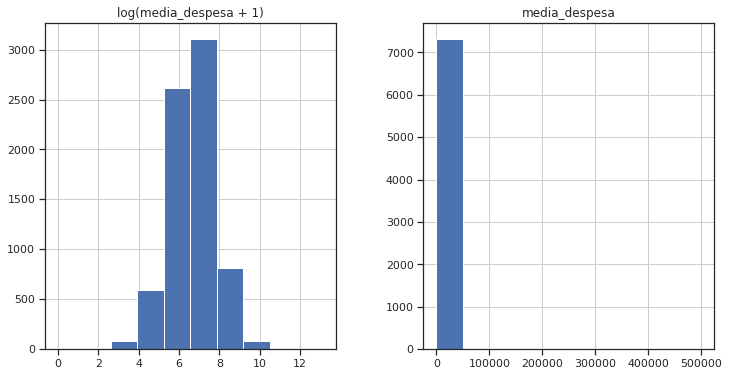

In [8]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
media_despesa = pd.DataFrame({"media_despesa" : candidates_df["media_despesa"], "log(media_despesa + 1)" : np.log1p(candidates_df["media_despesa"])})
media_despesa.hist()

In [9]:
numeric_features = candidates_df.dtypes[candidates_df.dtypes != 'object'].index

skewed_feats = candidates_df[numeric_features].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

print(skewed_feats)

candidates_df[skewed_feats] = np.log1p(candidates_df[skewed_feats])

Index(['quantidade_doacoes', 'quantidade_doadores', 'total_receita',
       'media_receita', 'recursos_de_outros_candidatos_comites',
       'recursos_de_pessoas_fisicas', 'recursos_de_pessoas_juridicas',
       'recursos_proprios', 'quantidade_despesas', 'quantidade_fornecedores',
       'total_despesa', 'media_despesa', 'votos'],
      dtype='object')


Importante notar que a variável-alvo **_votos_** também está incluída no conjunto de skewed variables, e não precisa ser transformada em separado.

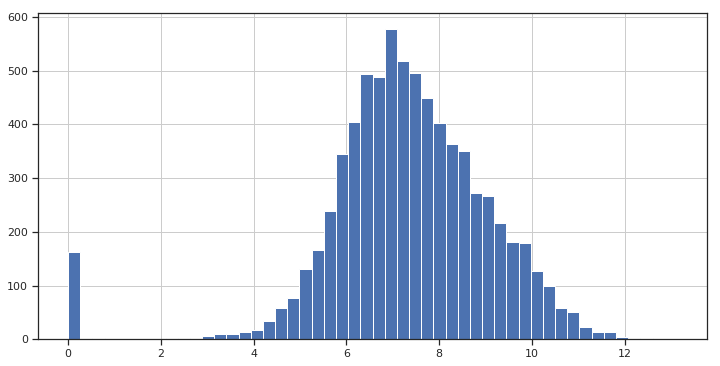

In [10]:
candidates_df.media_receita.hist(bins=50)

### Variáveis Categóricas

Como estamos trabalhando com modelos que apenas aceitam variáveis numéricas, precisamos também transformar variáveis categóricas do nosso dataset em variáveis numéricas com as quais nosso modelo de machine learning pode trabalhar. As variáveis não-numéricas (categóricas) que temos são as seguintes:

In [11]:
cat_variables = []

for col in candidates_df.columns:
    if not np.issubdtype(candidates_df[str(col)].dtype, np.number) and col != 'nome':
        cat_variables.append(col)
        print("Column [{:02}]: {:40}".format(candidates_df.columns.get_loc(str(col)), str(col)))

Column [01]: uf                                      
Column [02]: partido                                 
Column [15]: cargo                                   
Column [16]: sexo                                    
Column [17]: grau                                    
Column [18]: estado_civil                            
Column [19]: ocupacao                                


Vamos verificar a distribuição dessas variáveis, exceto **nome**, para entender como e se podemos transformar todas para um valor inteiro.

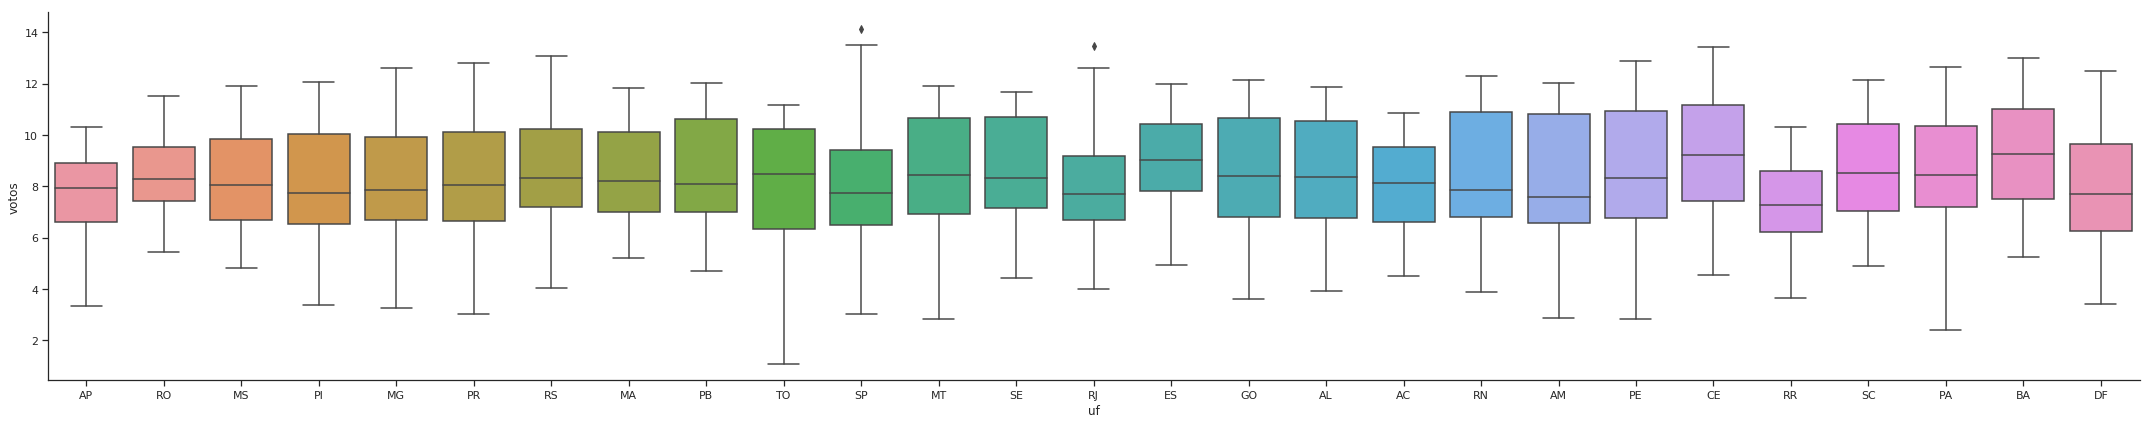

In [12]:
sns.catplot(x='uf', y='votos', data=candidates_df, aspect=5, height=6, kind='box')

Aqui podemos aplicar uma função e transformar cada estado para um código numérico:

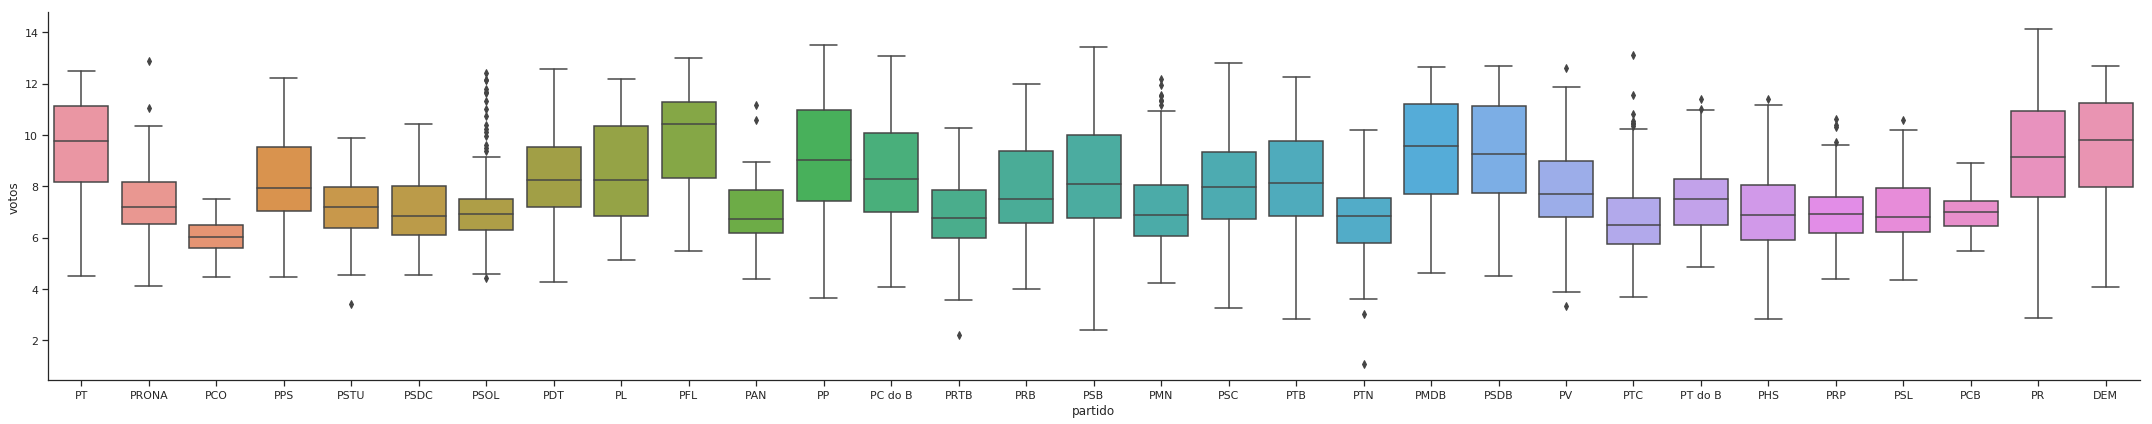

In [13]:
sns.catplot(x='partido', y='votos', data=candidates_df, aspect=5, height=6, kind='box')

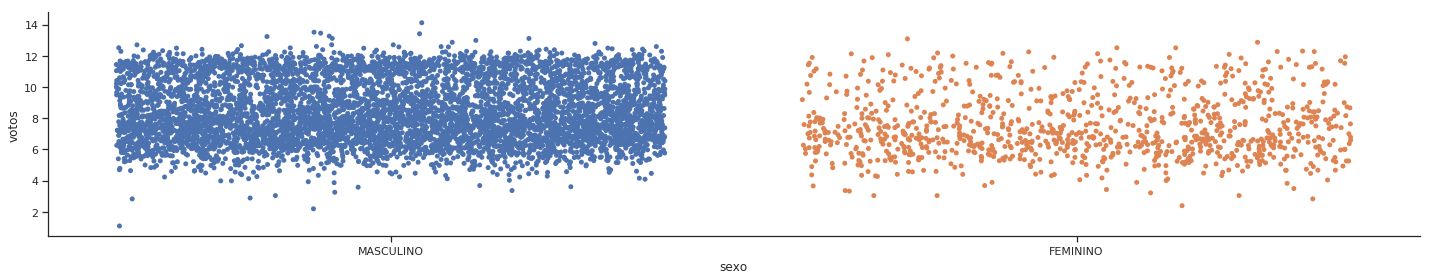

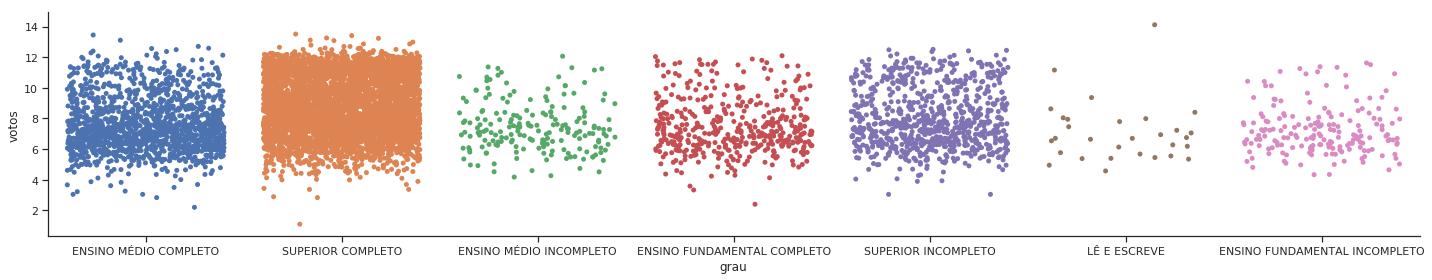

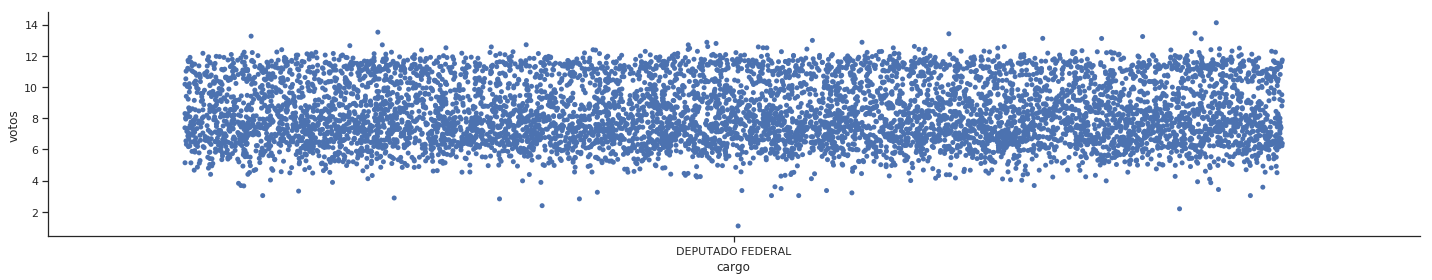

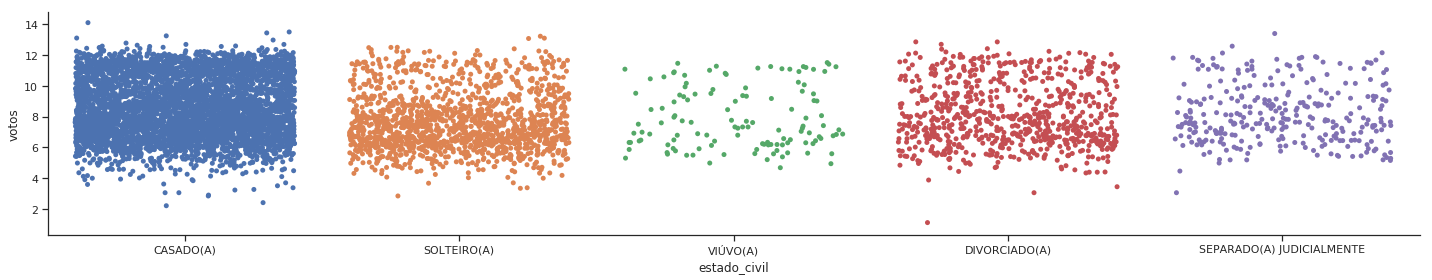

In [14]:
for col in ['sexo', 'grau', 'cargo', 'estado_civil']:
    sns.catplot(x=col, y='votos', data=candidates_df, jitter=.4, aspect=5, height=4)

Note que podemos tratar a variável **grau** como uma variável ordinária:

In [15]:
cleanup_nums = {"grau" : {"LÊ E ESCREVE": 1, 
                       "ENSINO FUNDAMENTAL INCOMPLETO":2, 
                       "ENSINO FUNDAMENTAL COMPLETO":3, 
                       "ENSINO MÉDIO INCOMPLETO":4,
                       "ENSINO MÉDIO COMPLETO":5,
                       "SUPERIOR INCOMPLETO":6,
                       "SUPERIOR COMPLETO": 7}}
candidates_df.replace(cleanup_nums, inplace=True)

candidates_df.grau.head()

0    5
1    7
2    7
3    4
4    3
Name: grau, dtype: int64

Para a variável **ocupacao** nós temos um conjunto muito grande de diferentes valores, o que inviabiliza a exposição gráfica de todos os valores, entretando nós expomos aqui as quantidades para as 20 ocupações mais comuns:

In [16]:
candidates_df.ocupacao.value_counts().head(20)

OUTROS                                            819
DEPUTADO                                          703
ADVOGADO                                          673
EMPRESÁRIO                                        629
VEREADOR                                          326
MÉDICO                                            325
COMERCIANTE                                       316
SERVIDOR PÚBLICO ESTADUAL                         248
SERVIDOR PÚBLICO FEDERAL                          214
PROFESSOR DE ENSINO MÉDIO                         172
ADMINISTRADOR                                     160
ENGENHEIRO                                        158
APOSENTADO (EXCETO SERVIDOR PÚBLICO)              153
POLICIAL MILITAR                                  149
PROFESSOR DE ENSINO SUPERIOR                      148
SERVIDOR PÚBLICO MUNICIPAL                        123
ESTUDANTE, BOLSISTA, ESTAGIÁRIO E ASSEMELHADOS     85
MILITAR REFORMADO                                  80
ECONOMISTA                  

### Dummy Variables

Para transformar essas variáveis categóricas em numéricas (dummy variables), utilizamos uma função especial da biblioteca _pandas_:

In [17]:
print(cat_variables)
candidates_df = pd.get_dummies(data=candidates_df, columns=cat_variables)
candidates_df.shape

['uf', 'partido', 'cargo', 'sexo', 'grau', 'estado_civil', 'ocupacao']


(7330, 262)

### Distribuição de Variáveis Numéricas

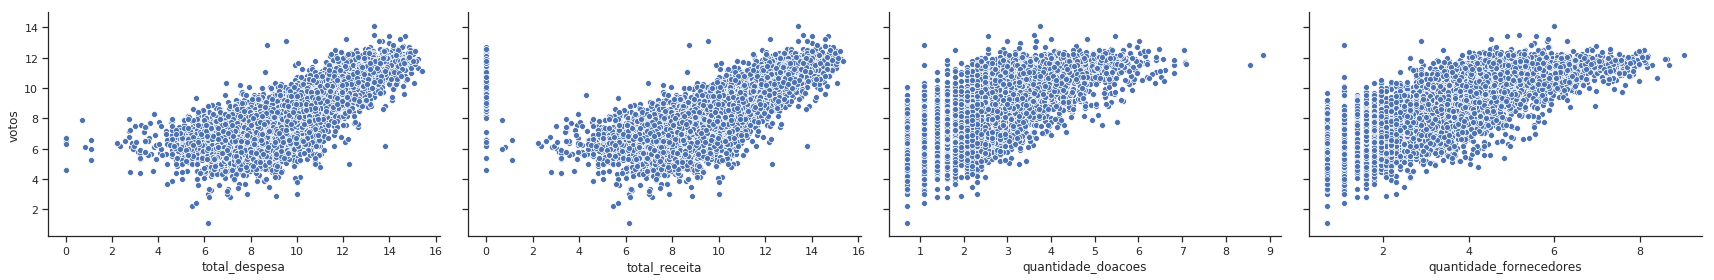

In [18]:
sns.pairplot(candidates_df, x_vars=['total_despesa', 'total_receita', 'quantidade_doacoes', 'quantidade_fornecedores'], y_vars=['votos'], aspect=1.5, height=4)

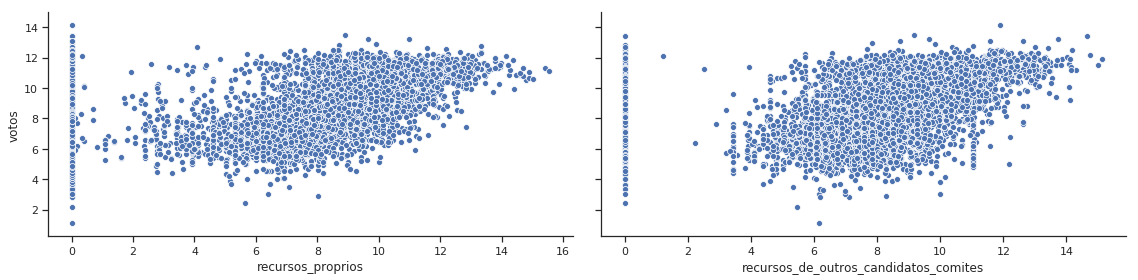

In [19]:
sns.pairplot(candidates_df, x_vars=['recursos_proprios', 'recursos_de_outros_candidatos_comites'], y_vars=['votos'], aspect=2, height=4)

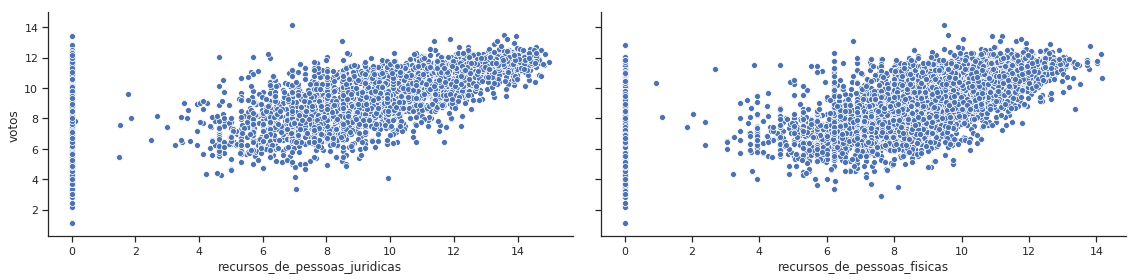

In [20]:
sns.pairplot(candidates_df, x_vars=['recursos_de_pessoas_juridicas', 'recursos_de_pessoas_fisicas'], y_vars=['votos'], aspect=2, height=4)

## Models

In [21]:
candidates_train = candidates_df[candidates_df.ano == 2006]
candidates_test = candidates_df[candidates_df.ano == 2010]

feats = candidates_df.columns[candidates_df.columns != 'votos']

X_train = candidates_train[feats]
y_train = candidates_train['votos']

X_test = candidates_test[feats]
y_test = candidates_test['votos']

Aqui nós vamos usar testar alguns modelos de regressão do scikit-learn em nosso dataset sem usar regularização (ridge e lasso) e em seguida utilizando.

Mas primeiro vamos usar uma função criada por [Alexandru Papiu - Regularized Linear Models](https://www.kaggle.com/apapiu/regularized-linear-models) para analisar os erros dos modelos propostos. A função utiliza validação cruzada com k = 5 (k-fold validation) e como função de score Negative Mean Squared Error.

In [22]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, LinearRegression
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

### Sem Regularização


In [28]:
lr = LinearRegression().fit(X_train, y_train)
rmse_cv(lr).mean()

715623343.2260275

Como podemos observar, os valores de RMSE para um modelo linear multivariado sem regularização tem um erro bastante elevado. Isso provavelmente se deve ao fato de está acontecendo overfitting. Uma simples olhada na ordem dos coeficientes do modelo nos permite observar isso. Caso os coeficientes sejam muito grandes, temos overfitting.

/home/guilherme/anaconda3/envs/ml-mestrado/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


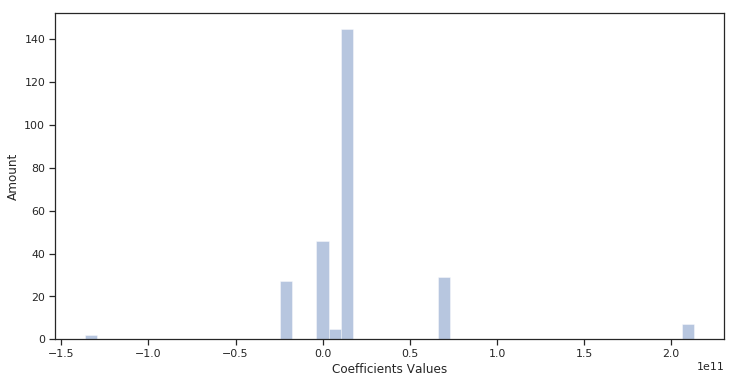

In [40]:
coefs = lr.coef_
ax = sns.distplot(coefs, kde=False)
ax.set(xlabel='Coefficients Values', ylabel='Amount')
plt.show()

### Com Regularização

#### Ridge

Text(0,0.5,'rmse')

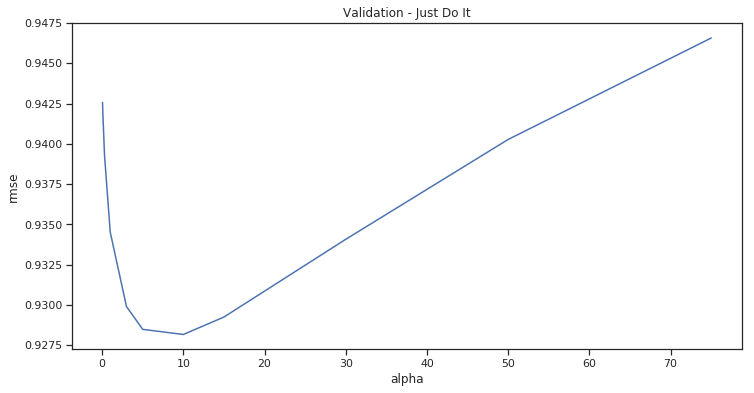

In [51]:
model_ridge = Ridge()

alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

O valor de **alpha** associado com o menor RMSE é **10**. Então vamos utilizar esse valor para configurar nosso modelo de regressão linear Ridge, o qual utiliza normalização **l2**. O valor de RMSE encontrado para alpha = 10 é em torno de 0.928.

In [64]:
cv_ridge.min()

0.9281697731979219

#### Lasso

In [76]:
model_lasso = LassoCV(alphas = [1, 5e-1, 1e-1, 5e-2, 1e-3, 1e-4, 1e-5,1e-6], max_iter=1e4).fit(X_train, y_train)
rmse_cv(model_lasso).mean()

0.9288344487702895

O modelo Ridge se sai um pouco melhor que o modelo Lasso. Entretanto, podemos fazer uma análise para identificar quais variáveis foram consideradas ou eliminadas pelo modelo de regressão Lasso.

In [69]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)

print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 15 variables and eliminated the other 246 variables


Text(0.5,1,'Coefficients in the Lasso Model')

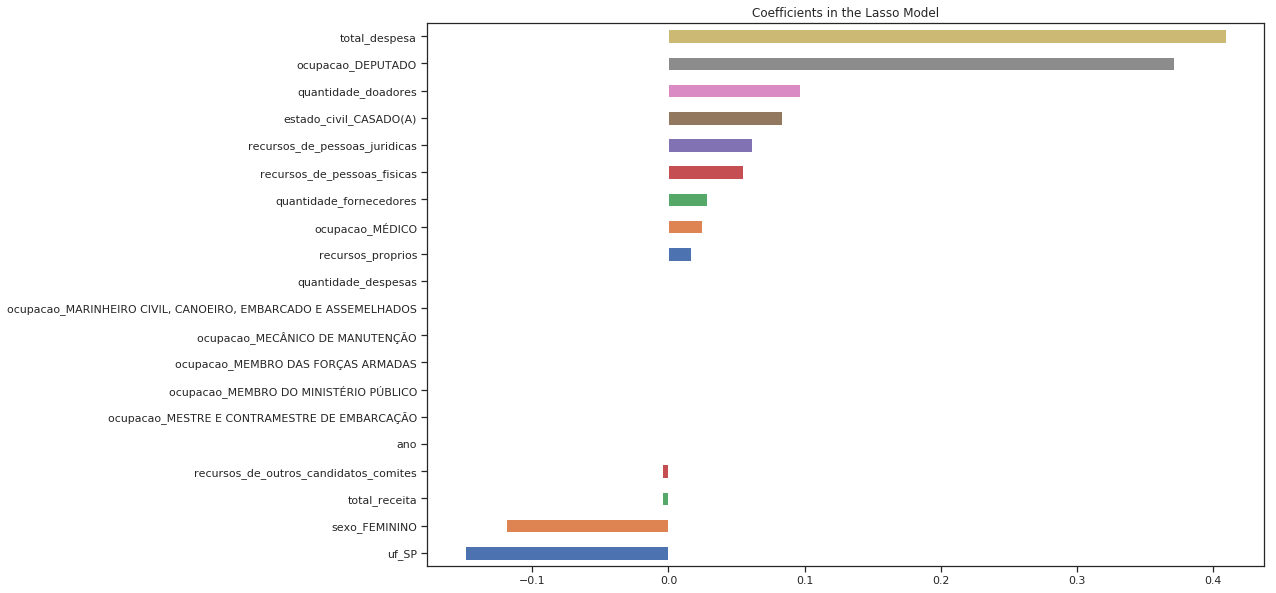

In [70]:
imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])

matplotlib.rcParams['figure.figsize'] = (15.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

Como podemos ver, o modelo Ridge consegue se sair melhor com o nosso dataset do que o modelo Lasso. O modelo Lasso eliminou um total de 246 variáveis e considerou apenas as 15 variáveis mais importantes destacadas acima.

O gráfico acima também nos permite visualizar que a variável considerada mais relevante para o modelo de predição é **total_despesa**, o que faz bastante sentido. Outra variável também bastante relevante é **ocupacao_DEPUTADO**, o que também faz sentido visto que a pessoa está tentando uma reeleição e provavelmente já é conhecido, tem uma base eleitoral, etc.

Outras variáveis, que o modelo curiosamente considera como uma contribuição negativa para a arrecadação de votos, são **sexo_FEMININO** e **uf_SP**. Algumas hipóteses podem ser levantadas, embora ainda se precise de maiores avaliações:

1. Existe uma barreira ou uma resistência quanto à entrada de mulheres na política, isso pode se comprovar na própria composição do nosso congresso nacional, o qual tem um número muito baixo de mulheres;
2. O fato de um indivíduo ser de São Paulo deve contribuir negativamente devido ao desbalanceamento nos dados que temos. É provável que tenhamos muito mais candidatos originários de SP, maior colégio eleitoral do país, se fizermos uma comparação com outros estados.

In [94]:
for col in candidates_df.columns:
    if 'uf_' in col:
        print("Estado: {} -> Numero de Candidatos: {}".format(col, candidates_df[col].sum()))

Estado: uf_AC -> Numero de Candidatos: 69
Estado: uf_AL -> Numero de Candidatos: 104
Estado: uf_AM -> Numero de Candidatos: 93
Estado: uf_AP -> Numero de Candidatos: 106
Estado: uf_BA -> Numero de Candidatos: 311
Estado: uf_CE -> Numero de Candidatos: 171
Estado: uf_DF -> Numero de Candidatos: 143
Estado: uf_ES -> Numero de Candidatos: 136
Estado: uf_GO -> Numero de Candidatos: 175
Estado: uf_MA -> Numero de Candidatos: 190
Estado: uf_MG -> Numero de Candidatos: 811
Estado: uf_MS -> Numero de Candidatos: 125
Estado: uf_MT -> Numero de Candidatos: 101
Estado: uf_PA -> Numero de Candidatos: 186
Estado: uf_PB -> Numero de Candidatos: 125
Estado: uf_PE -> Numero de Candidatos: 210
Estado: uf_PI -> Numero de Candidatos: 122
Estado: uf_PR -> Numero de Candidatos: 404
Estado: uf_RJ -> Numero de Candidatos: 973
Estado: uf_RN -> Numero de Candidatos: 76
Estado: uf_RO -> Numero de Candidatos: 119
Estado: uf_RR -> Numero de Candidatos: 104
Estado: uf_RS -> Numero de Candidatos: 437
Estado: uf_SC 

### Non-Parameterized Models

#### KNN (K-Nearest Neighbors)

In [42]:
from sklearn.neighbors import KNeighborsRegressor

reg = KNeighborsRegressor(n_neighbors = 3)

reg.fit(X_train, y_train)

print("Test set predictions: \n{}".format(reg.predict(X_test)))
print("Test set R²: {:.2f}".format(reg.score(X_test, y_test)))

Test set predictions: 
[10.27152184  8.60332467  6.25125981 ...  7.80995887  8.68376513
  9.92882965]
Test set R²: 0.67


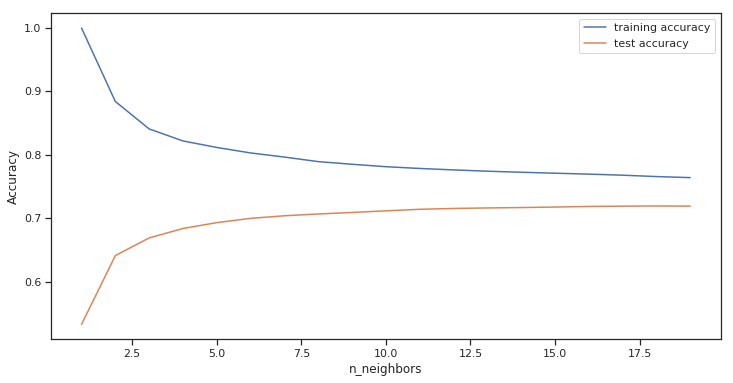

In [45]:
training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 15
neighbors_settings = range(1, 15)

for n_neighbors in neighbors_settings:
    # build the model
    clf = KNeighborsRegressor(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(clf.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(clf.score(X_test, y_test))
    
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()